In [52]:
# Name:Rohit Yadav (6219913)
# House Price prediction
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = '../input/'
#path = 'dataset/'
train = pd.read_csv('Desktop/HousePricesDataset/train.csv')
test = pd.read_csv('Desktop/HousePricesDataset/test.csv')
print('Number of rows and columns in train dataset:', train.shape)
print('Number of rows and columns in test dataset:', test.shape)

('Number of rows and columns in train dataset:', (1460, 81))
('Number of rows and columns in test dataset:', (1459, 80))


In [6]:
datasetHasNan = False
if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] :
    print('We do not need to worry about missing values.') 
else:
    datasetHasNan = True
    print('yes, we have missing values')

# now list items    
print('--'*40) 
if datasetHasNan == True:
    nas = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

yes, we have missing values
--------------------------------------------------------------------------------
Nan in the data sets
              Train Dataset  Test Dataset
Alley                  1369        1352.0
BsmtCond                 37          45.0
BsmtExposure             38          44.0
BsmtFinSF1                0           1.0
BsmtFinSF2                0           1.0
BsmtFinType1             37          42.0
BsmtFinType2             38          42.0
BsmtFullBath              0           2.0
BsmtHalfBath              0           2.0
BsmtQual                 37          44.0
BsmtUnfSF                 0           1.0
Electrical                1           0.0
Exterior1st               0           1.0
Exterior2nd               0           1.0
Fence                  1179        1169.0
FireplaceQu             690         730.0
Functional                0           2.0
GarageArea                0           1.0
GarageCars                0           1.0
GarageCond               81   

In [8]:
# Explore features
def feat_explore(column):
    return train[column].value_counts()

# Function to impute missing values
def feat_impute(column, value):
    train.loc[train[column].isnull(),column] = value
    test.loc[test[column].isnull(),column] = value

In [9]:
#PoolQC, MiscFeature, Alley, Fence will all be removed as they are missing over half of their observations.(Over 50% Missing)

features_drop = ['PoolQC','MiscFeature','Alley','Fence']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1) 

In [11]:
print('TRAIN: FireplaceQu Missing Before:', train['FireplaceQu'].isnull().sum(),'\n',
      'TEST: FireplaceQu Missing Before:', test['FireplaceQu'].isnull().sum())

('TRAIN: FireplaceQu Missing Before:', 690, '\n', 'TEST: FireplaceQu Missing Before:', 730)


In [9]:
#TRAIN: missing 690 observations. 
#TEST: missing 730 observations. 
#However, these nulls may be attributed to homes that do not have fireplaces at all. 
#If this assumption proves to be true, we can impute these nulls with '0' as they do not have a fireplace.

# checking this assumption
assumption1 = pd.concat([(train[train['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']]),
                (test[test['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']])], 
                axis=1, keys=['Train Dataset',' Test Dataset']) 
print(assumption1)

     Train Dataset              Test Dataset            
        Fireplaces FireplaceQu    Fireplaces FireplaceQu
0              0.0         NaN           0.0         NaN
1              NaN         NaN           0.0         NaN
4              NaN         NaN           0.0         NaN
5              0.0         NaN           NaN         NaN
6              NaN         NaN           0.0         NaN
9              NaN         NaN           0.0         NaN
10             0.0         NaN           NaN         NaN
11             NaN         NaN           0.0         NaN
12             0.0         NaN           0.0         NaN
14             NaN         NaN           0.0         NaN
15             0.0         NaN           NaN         NaN
16             NaN         NaN           0.0         NaN
17             0.0         NaN           NaN         NaN
18             0.0         NaN           NaN         NaN
19             0.0         NaN           NaN         NaN
22             NaN         NaN 

In [12]:
print('TRAIN: shape :', (train[train['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']].shape),
        '\n','TEST: shape :',  (train[train['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']].shape))

('TRAIN: shape :', (690, 2), '\n', 'TEST: shape :', (690, 2))


In [13]:
# Impute the nulls with None 
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
test['FireplaceQu'] = test['FireplaceQu'].fillna('None')

# Cross check columns
print('Confirm Imputation for train')
print(pd.crosstab(train.FireplaceQu,train.Fireplaces,))
print('--'*40)
print('Confirm Imputation for test')
print(pd.crosstab(test.FireplaceQu,test.Fireplaces,))

Confirm Imputation for train
Fireplaces     0    1   2  3
FireplaceQu                 
Ex             0   19   4  1
Fa             0   28   4  1
Gd             0  324  54  2
None         690    0   0  0
Po             0   20   0  0
TA             0  259  53  1
--------------------------------------------------------------------------------
Confirm Imputation for test
Fireplaces     0    1   2  3  4
FireplaceQu                    
Ex             0   18   1  0  0
Fa             0   35   6  0  0
Gd             0  303  58  3  0
None         730    0   0  0  0
Po             0   26   0  0  0
TA             0  236  39  3  1


In [12]:
print('TRAIN: LotFrontage Missing Before:', train['LotFrontage'].isnull().sum(),'\n','TEST: LotFrontage Missing Before:', test['LotFrontage'].isnull().sum())

('TRAIN: LotFrontage Missing Before:', 259, '\n', 'TEST: LotFrontage Missing Before:', 227)


In [14]:
#TRAIN: missing 259 observations. 
#TEST: missing 227 observations. 
#First check if there are other variables that are strongly correlated with LotFrontage can be used for imputation. 
#Otherwise impute with the median LotFrontage value.

# Check above mentioned assumption
corr_lf = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict_lf = corr_lf['LotFrontage'].to_dict()
del cor_dict_lf['LotFrontage']
print("Numeric features by Correlation with LotFrontage:\n")
for ele in sorted(cor_dict_lf.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

Numeric features by Correlation with LotFrontage:

1stFlrSF: 	0.457181001995
LotArea: 	0.426095018772
GrLivArea: 	0.402797414085
TotalBsmtSF: 	0.392074576379
MSSubClass: 	-0.386346885345
TotRmsAbvGrd: 	0.35209594766
SalePrice: 	0.351799096571
GarageArea: 	0.344996724106
GarageCars: 	0.285690924685
Fireplaces: 	0.26663948256
BedroomAbvGr: 	0.263169915881
OverallQual: 	0.251645775481
BsmtFinSF1: 	0.23363316702
PoolArea: 	0.206166775276
FullBath: 	0.198768677897
MasVnrArea: 	0.193458060558
OpenPorchSF: 	0.151972227681
BsmtUnfSF: 	0.132643741625
YearBuilt: 	0.123349467033
BsmtFullBath: 	0.100948566949
YearRemodAdd: 	0.0888655724921
WoodDeckSF: 	0.0885209332894
2ndFlrSF: 	0.0801772706242
GarageYrBlt: 	0.0702497819166
3SsnPorch: 	0.0700292277309
OverallCond: 	-0.0592134500052
HalfBath: 	0.0535318549796
BsmtFinSF2: 	0.049899676691
ScreenPorch: 	0.041382790675
LowQualFinSF: 	0.038468534329
MoSold: 	0.0111999547591
EnclosedPorch: 	0.0107003366389
YrSold: 	0.00744958920978
BsmtHalfBath: 	-0.0072

In [15]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())

In [14]:
#TRAIN: missing 259 observations. 
#TEST: missing 227 observations. 
#First check if there are other variables that are strongly correlated with LotFrontage can be used for imputation. 
#Otherwise impute with the median LotFrontage value.

# Check above mentioned assumption
corr_lf = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict_lf = corr_lf['LotFrontage'].to_dict()
del cor_dict_lf['LotFrontage']
print("Numeric features by Correlation with LotFrontage:\n")
for ele in sorted(cor_dict_lf.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

Numeric features by Correlation with LotFrontage:

1stFlrSF: 	0.457181001995
LotArea: 	0.426095018772
GrLivArea: 	0.402797414085
TotalBsmtSF: 	0.392074576379
MSSubClass: 	-0.386346885345
TotRmsAbvGrd: 	0.35209594766
SalePrice: 	0.351799096571
GarageArea: 	0.344996724106
GarageCars: 	0.285690924685
Fireplaces: 	0.26663948256
BedroomAbvGr: 	0.263169915881
OverallQual: 	0.251645775481
BsmtFinSF1: 	0.23363316702
PoolArea: 	0.206166775276
FullBath: 	0.198768677897
MasVnrArea: 	0.193458060558
OpenPorchSF: 	0.151972227681
BsmtUnfSF: 	0.132643741625
YearBuilt: 	0.123349467033
BsmtFullBath: 	0.100948566949
YearRemodAdd: 	0.0888655724921
WoodDeckSF: 	0.0885209332894
2ndFlrSF: 	0.0801772706242
GarageYrBlt: 	0.0702497819166
3SsnPorch: 	0.0700292277309
OverallCond: 	-0.0592134500052
HalfBath: 	0.0535318549796
BsmtFinSF2: 	0.049899676691
ScreenPorch: 	0.041382790675
LowQualFinSF: 	0.038468534329
MoSold: 	0.0111999547591
EnclosedPorch: 	0.0107003366389
YrSold: 	0.00744958920978
BsmtHalfBath: 	-0.0072

In [15]:
# Nothing highly correlated to LotFrontage so we will impute with the mean

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())

In [16]:
print('Garage Features Missing Before')
print('--'*40)
print(pd.concat([(train[['GarageYrBlt', 'GarageType', 'GarageFinish','GarageQual','GarageCond']].isnull().sum()),
                (train[['GarageYrBlt', 'GarageType', 'GarageFinish','GarageQual','GarageCond']].isnull().sum())], 
                axis=1, keys=['Train Dataset',' Test Dataset']) )

Garage Features Missing Before
--------------------------------------------------------------------------------
              Train Dataset   Test Dataset
GarageYrBlt              81             81
GarageType               81             81
GarageFinish             81             81
GarageQual               81             81
GarageCond               81             81


In [17]:
#TRAIN: missing 259 observations. 
#TEST: missing 227 observations. 
#These null values are assumed to be in the same rows for each column and associated with homes 
#that do not have garages at all. 
#If these assumptions are correct, the nulls can be inputed with zero as these are properties without garages.

# Assumptions check
print('--'*40)
print('Assumption Check TRAIN DATASET')
null_garage = ['GarageYrBlt','GarageType','GarageQual','GarageCond','GarageFinish']
print(train[(train['GarageYrBlt'].isnull())|
                 (train['GarageType'].isnull())|
                 (train['GarageQual'].isnull())|
                 (train['GarageCond'].isnull())|
                 (train['GarageFinish'].isnull())]
                 [['GarageCars','GarageYrBlt','GarageType','GarageQual','GarageCond','GarageFinish']])
print('--'*40)
print('Assumption Check TEST DATASET')
print(test[(test['GarageYrBlt'].isnull())|
                 (test['GarageCond'].isnull())|
                 (test['GarageQual'].isnull())|
                (test['GarageFinish'].isnull())|
                (test['GarageType'].isnull())|
                (test['GarageCars'].isnull())|
                (test['GarageArea'].isnull())]
                 [['GarageYrBlt','GarageCond','GarageQual', 'GarageFinish','GarageType','GarageCars','GarageArea']])

--------------------------------------------------------------------------------
Assumption Check TRAIN DATASET
      GarageCars  GarageYrBlt GarageType GarageQual GarageCond GarageFinish
39             0          NaN        NaN        NaN        NaN          NaN
48             0          NaN        NaN        NaN        NaN          NaN
78             0          NaN        NaN        NaN        NaN          NaN
88             0          NaN        NaN        NaN        NaN          NaN
89             0          NaN        NaN        NaN        NaN          NaN
99             0          NaN        NaN        NaN        NaN          NaN
108            0          NaN        NaN        NaN        NaN          NaN
125            0          NaN        NaN        NaN        NaN          NaN
127            0          NaN        NaN        NaN        NaN          NaN
140            0          NaN        NaN        NaN        NaN          NaN
148            0          NaN        NaN        NaN 

In [18]:
# Impute nulls at index 666 that have a garage with most common value in each column for categorical variables 
test.iloc[666, test.columns.get_loc('GarageYrBlt')] = test['GarageYrBlt'].mode()[0]
test.iloc[666, test.columns.get_loc('GarageCond')] = test['GarageCond'].mode()[0]
test.iloc[666, test.columns.get_loc('GarageFinish')] = test['GarageFinish'].mode()[0]
test.iloc[666, test.columns.get_loc('GarageQual')] = test['GarageQual'].mode()[0]
test.iloc[666, test.columns.get_loc('GarageType')] = test['GarageType'].mode()[0]

# Impute nulls at index 1116 that have a garage with most common value in each column for categorical variables 
test.iloc[1116, test.columns.get_loc('GarageYrBlt')] = test['GarageYrBlt'].mode()[0]
test.iloc[1116, test.columns.get_loc('GarageCond')] = test['GarageCond'].mode()[0]
test.iloc[1116, test.columns.get_loc('GarageFinish')] = test['GarageFinish'].mode()[0]
test.iloc[1116, test.columns.get_loc('GarageQual')] = test['GarageQual'].mode()[0]
test.iloc[1116, test.columns.get_loc('GarageType')] = test['GarageType'].mode()[0]

# Impute nulls at index 1116 that have a garage with median value in each column for continuous variables 
test.iloc[1116, test.columns.get_loc('GarageCars')] = test['GarageCars'].median()
test.iloc[1116, test.columns.get_loc('GarageArea')] = test['GarageArea'].median()

In [19]:
# Impute the remaining nulls as None
null_garage2 = ['GarageYrBlt','GarageCond','GarageFinish','GarageQual', 'GarageType','GarageCars','GarageArea']

for cols in null_garage2:
    if(train[cols].dtype ==np.object)&(test[cols].dtype ==np.object) :
         feat_impute(cols, 'None')
    else:
         feat_impute(cols, 0)

In [20]:
# Cross check columns

print('Confirm Imputation')
for cols in null_garage:
    print(pd.crosstab(train[cols],train.GarageCars))
    print(pd.crosstab(test[cols],test.GarageCars))

Confirm Imputation
GarageCars    0   1   2   3  4
GarageYrBlt                   
0.0          81   0   0   0  0
1900.0        0   0   1   0  0
1906.0        0   1   0   0  0
1908.0        0   0   1   0  0
1910.0        0   1   2   0  0
1914.0        0   1   1   0  0
1915.0        0   2   0   0  0
1916.0        0   4   0   1  0
1918.0        0   0   1   1  0
1920.0        0  10   3   1  0
1921.0        0   2   1   0  0
1922.0        0   4   1   0  0
1923.0        0   2   1   0  0
1924.0        0   3   0   0  0
1925.0        0   7   3   0  0
1926.0        0   6   0   0  0
1927.0        0   0   1   0  0
1928.0        0   3   1   0  0
1929.0        0   1   1   0  0
1930.0        0   5   3   0  0
1931.0        0   2   2   0  0
1932.0        0   1   2   0  0
1933.0        0   1   0   0  0
1934.0        0   1   1   0  0
1935.0        0   2   2   0  0
1936.0        0   5   0   0  0
1937.0        0   2   0   0  0
1938.0        0   3   0   0  0
1939.0        0   7   2   0  0
1940.0        0  13 

In [21]:
null_bsmt = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
             'TotalBsmtSF','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2']
print('Missing Data Before','\n')
for cols in null_bsmt:
    print('TRAIN:',cols,train[cols].isnull().sum())
    print('TEST:',cols,test[cols].isnull().sum())
    print('--'*40)

('Missing Data Before', '\n')
('TRAIN:', 'BsmtFullBath', 0)
('TEST:', 'BsmtFullBath', 2)
--------------------------------------------------------------------------------
('TRAIN:', 'BsmtHalfBath', 0)
('TEST:', 'BsmtHalfBath', 2)
--------------------------------------------------------------------------------
('TRAIN:', 'BsmtFinSF1', 0)
('TEST:', 'BsmtFinSF1', 1)
--------------------------------------------------------------------------------
('TRAIN:', 'BsmtFinSF2', 0)
('TEST:', 'BsmtFinSF2', 1)
--------------------------------------------------------------------------------
('TRAIN:', 'BsmtUnfSF', 0)
('TEST:', 'BsmtUnfSF', 1)
--------------------------------------------------------------------------------
('TRAIN:', 'TotalBsmtSF', 0)
('TEST:', 'TotalBsmtSF', 1)
--------------------------------------------------------------------------------
('TRAIN:', 'BsmtCond', 37)
('TEST:', 'BsmtCond', 45)
--------------------------------------------------------------------------------
('TRAIN:', '

In [22]:
train['BsmtQual'].fillna('NA', inplace = True)
test['BsmtQual'].fillna('NA', inplace = True)

train['BsmtCond'].fillna('NA', inplace = True)
test['BsmtCond'].fillna('NA', inplace = True)

train['BsmtExposure'].fillna('NA', inplace = True)
test['BsmtExposure'].fillna('NA', inplace = True)

train['BsmtFinType1'].fillna('NA', inplace = True)
test['BsmtFinType1'].fillna('NA', inplace = True)

train['BsmtFinType2'].fillna('NA', inplace = True)
test['BsmtFinType2'].fillna('NA', inplace = True)

test['BsmtFullBath'].fillna('NA', inplace = True)
test['BsmtHalfBath'].fillna('NA', inplace = True)
test['BsmtFinSF1'].fillna('NA', inplace = True)
test['BsmtFinSF2'].fillna('NA', inplace = True)

In [27]:
print('Masonry Features Missing Before')
print(pd.concat([(train[['MasVnrArea', 'MasVnrType']].isnull().sum()),
                (test[['MasVnrArea', 'MasVnrType']].isnull().sum())], 
                axis=1, keys=['Train Dataset',' Test Dataset']) )

Masonry Features Missing Before
            Train Dataset   Test Dataset
MasVnrArea              8             15
MasVnrType              8             16


In [28]:
# MasVnrArea and MasVnrType are each missing 8 observations
# Confirm that the missing values in these columns are the same rows
print('Check Assumptions FOR TRAIN SET')
print(train[(train['MasVnrArea'].isnull())|(train['MasVnrType'].isnull())]
                 [['MasVnrArea','MasVnrType']])

print(train[(train['MasVnrArea'].isnull())|(train['MasVnrType'].isnull())]
                 [['MasVnrArea','MasVnrType']].shape)

# View nulls in masonry features in Test set now
print('--'*40,'\nAssumption Check FOR TEST SET')
print(test[(test['MasVnrType'].isnull())|(test['MasVnrType'].isnull())|
                (test['MasVnrArea'].isnull())|(test['MasVnrArea'].isnull())]
                 [['MasVnrType','MasVnrArea']])

Check Assumptions FOR TRAIN SET
      MasVnrArea MasVnrType
234          NaN        NaN
529          NaN        NaN
650          NaN        NaN
936          NaN        NaN
973          NaN        NaN
977          NaN        NaN
1243         NaN        NaN
1278         NaN        NaN
(8, 2)
('--------------------------------------------------------------------------------', '\nAssumption Check FOR TEST SET')
     MasVnrType  MasVnrArea
231         NaN         NaN
246         NaN         NaN
422         NaN         NaN
532         NaN         NaN
544         NaN         NaN
581         NaN         NaN
851         NaN         NaN
865         NaN         NaN
880         NaN         NaN
889         NaN         NaN
908         NaN         NaN
1132        NaN         NaN
1150        NaN       198.0
1197        NaN         NaN
1226        NaN         NaN
1402        NaN         NaN


In [29]:
# Impute `MasVnrArea` with the most frequent values
# feat_explore('MasVnrArea')
# feat_impute('MasVnrArea','None')
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mode()[0])

# Impute `MasVnrType` with the most frequent values
# feat_explore('MasVnrType')
# feat_impute('MasVnrType',0.0)

# Impute exceptions to assumption that nulls correspond to homes with no exposure
test.iloc[1150, test.columns.get_loc('MasVnrType')] = test['MasVnrType'].mode()[0]

train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].mode()[0])

In [30]:
# create list 
null_masonry = ['MasVnrType','MasVnrArea']

for cols in null_masonry:
    if((train[cols].dtype ==np.object)&(test[cols].dtype ==np.object)):
        feat_impute(cols, 'None')
    else:
        feat_impute(cols, 0)

In [31]:
# Electrical is only missing one value

print('Electrical Feature Missing Before')
print(train[['Electrical']].isnull().sum())

Electrical Feature Missing Before
Electrical    1
dtype: int64


In [32]:
# Impute Electrical with the most frequent value, 'SBrkr'
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

#check now
print('Electrical Feature Missing After')
print(train[['Electrical']].isnull().sum())
print('--'*40)

Electrical Feature Missing After
Electrical    0
dtype: int64
--------------------------------------------------------------------------------


In [33]:
null_others = ['MSZoning', 'Utilities','Functional','Exterior2nd','Exterior1st','SaleType','KitchenQual'] 

print('REMAINING Missing Data TEST SET')

for cols in null_others:
    print(cols,test[cols].isnull().sum())
    
print('--'*30,'\n','REMAINING Missing Data TRAIN SET')

for cols in null_others:
    print(cols,train[cols].isnull().sum())

REMAINING Missing Data TEST SET
('MSZoning', 4)
('Utilities', 2)
('Functional', 2)
('Exterior2nd', 1)
('Exterior1st', 1)
('SaleType', 1)
('KitchenQual', 1)
('------------------------------------------------------------', '\n', 'REMAINING Missing Data TRAIN SET')
('MSZoning', 0)
('Utilities', 0)
('Functional', 0)
('Exterior2nd', 0)
('Exterior1st', 0)
('SaleType', 0)
('KitchenQual', 0)


In [34]:
for cols in null_others:
    test[cols] = test[cols].mode()[0]

print('--'*40)
print('TEST SET : Missing Data After Imputation')
for cols in null_others:
    print(cols,test[cols].isnull().sum())

--------------------------------------------------------------------------------
TEST SET : Missing Data After Imputation
('MSZoning', 0)
('Utilities', 0)
('Functional', 0)
('Exterior2nd', 0)
('Exterior1st', 0)
('SaleType', 0)
('KitchenQual', 0)


In [36]:
#Proposed feature: '1stFlrSF' + '2ndFlrSF' to give us combined Floor Square Footage

try_feature = (train['1stFlrSF'] + train['2ndFlrSF']).copy()
print("Skewness of the original intended feature:",skew(try_feature))
print("Skewness of transformed feature", skew(np.log1p(try_feature)))

('Skewness of the original intended feature:', 1.3291026531678385)
('Skewness of transformed feature', -0.03365667635294192)


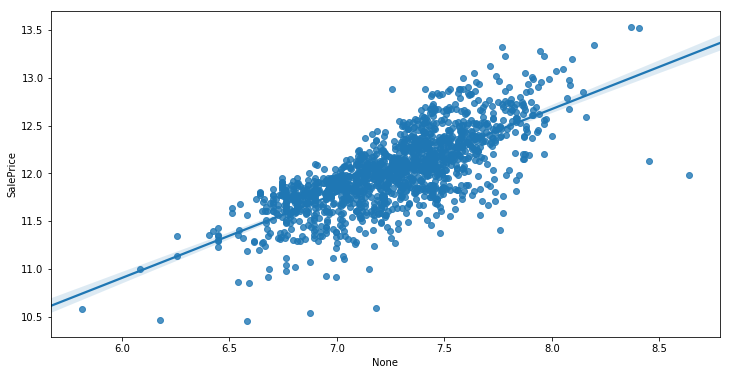

In [37]:
# we'll use the transformed feature:)
try_feature = np.log1p(try_feature)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot
sns.regplot(x=(try_feature), y=np.log1p(train['SalePrice']), data=train, order=1);

In [38]:
# lets create the feature then
train['1stFlr_2ndFlr_Sf'] = np.log1p(train['1stFlrSF'] + train['2ndFlrSF'])
test['1stFlr_2ndFlr_Sf'] = np.log1p(test['1stFlrSF'] + test['2ndFlrSF'])

In [39]:
#Feature number 2 -> 1stflr+2ndflr+lowqualsf+GrLivArea = All_Liv_Area
try_feature = (train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea']).copy()
print("Skewness of the original intended feature:",skew(try_feature))
print("Skewness of transformed feature", skew(np.log1p(try_feature)))

('Skewness of the original intended feature:', 1.427345461344283)
('Skewness of transformed feature', 0.022891569554582644)


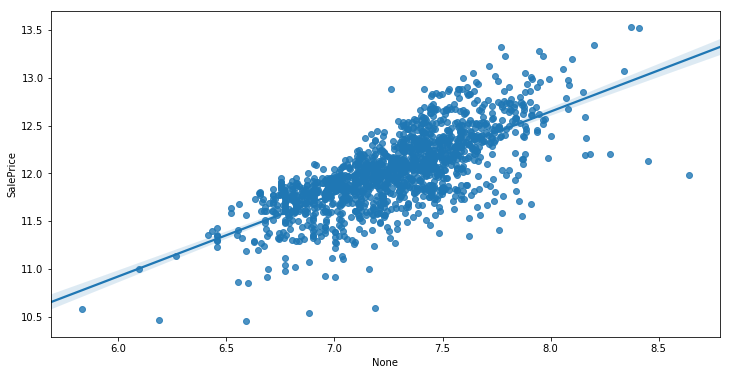

In [40]:
# hence, we'll use the transformed feature
try_feature = np.log1p(try_feature)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot 
sns.regplot(x=(try_feature), y=np.log1p(train['SalePrice']), data=train, order=1);

In [41]:
train['All_Liv_SF'] = np.log1p(train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea'])
test['All_Liv_SF'] = np.log1p(test['1stFlr_2ndFlr_Sf'] + test['LowQualFinSF'] + test['GrLivArea'])

In [42]:
# get all features except Id and SalePrice
feats = train.columns.difference(['Id','SalePrice'])

# the most hassle free way of working with data is to concatenate them
data_combo = pd.concat((train.loc[:,feats],
                      test.loc[:,feats]))

# But first, we log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [43]:
numeric_feats = data_combo.dtypes[data_combo.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data_combo[skewed_feats] = np.log1p(data_combo[skewed_feats])

In [44]:
# getting dummies for all features. 

data_combo = pd.get_dummies(data_combo)

In [45]:
print(data_combo.shape)

(2919, 1557)


In [46]:
# creating matrices for sklearn:

X_train = data_combo[:train.shape[0]]
X_test = data_combo[train.shape[0]:]
y = train.SalePrice

In [53]:
#But first, Let's devise a cross-validation methodology once and for all

from sklearn.model_selection  import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [54]:
# first import library
from sklearn.linear_model import LassoCV

#now create our object
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 0.12248799239421615)
('Min: ', 0.10273186844817653)


In [55]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 117 variables and eliminated the other 1440 variables


Text(0.5,1,'Coefficients in the Lasso Model')

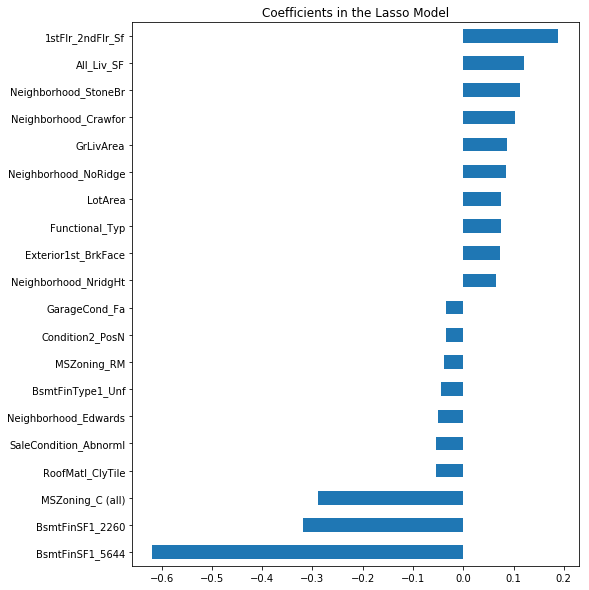

In [57]:
 #plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")